# Large Language Models Performance on Sentiment Analysis: A Comparative Study

**Author:** Abhi Vellore  
**Project completed for:** SML 310: Research Projects in Data Science

## Overview
This project utilizes Large Language Models (LLMs), including GPT-3.5, GPT-4.0, and LLaMA-7B for sentiment analysis across 3 datasets. The goal is to evaluate and compare their efficacy in understanding and predicting sentiment within various contexts.

## Table of Contents
1. [Preprocess Data](#Preprocess-Data)
   - [Imports](###Imports)
   - [Data Cleaning and Saving](###Data-Cleaning)
2. [Models and Experiments](#Models-and-Experiments)
   - [Set up and Save Functions](###Set-up-and-Save-Functions)
   - [GPT Model](###GPT-Model)
   - [Llama Models](###Llama-Models)
3. [Evaluation Metrics](#Evaluation-Metrics)
   - [Metrics per Model](###Metrics-per-Model-per-Dataset)
   - [Aggregated Metrics](###Aggregated-Metrics-Across-all-Datasets-Per-Model)

## Dependencies
This notebook relies on several key Python libraries including Pandas, NumPy, Matplotlib, Seaborn, and SciKit-Learn. The use of OpenAI's models and Meta's open-source LLaMA models was also critical.

## Datasets
The datasets used in this analysis are sourced from a variety of repositories which are referenced at the point of use within this notebook.

## Citations
Whenever external resources or pre-trained models like GPT-4.0 are employed, appropriate citations are provided in the corresponding sections.

---


# Preprocess Data

### Imports

In [1]:
from pre_process import AmazonDatasetPreprocessor, KaggleDatasetPreprocessor, SentenceDatasetPreprocessor
from config import PROCESSED_DATA_PATH
import os
import pandas as pd
from gpt import ChatGPTSession
from llama import LLaMaSession

from credentials import openai_api_key, llama_api_key

### Data-Cleaning

Datasets:
1. **Amazon_Fashion_Review_Data**: Justifying recommendations using distantly-labeled reviews and fined-grained aspects
Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019
2. **Kaggle Train** and **Kaggle Test**: Shrivastava, A. (2023). Sentiment Analysis Dataset. Kaggle. Retrieved April 1, 2024, from https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset/data
3. **Sentences_75Agree**: Malo, P., Sinha, A., Korhonen, P., Wallenius, J., & Takala, P. (2014). Good debt or bad debt: Detecting semantic orientations in economic texts. *Journal of the Association for Information Science and Technology*, 65.

Each dataset is initially stored as "unprocessed." After processing, will be stored in the "processed" folder. Processing is done through the script pre_process.py.

The Kaggle datasets are combined to have a larger dataset, and then randomly sampled from to be around the same size as the other datasets.

In [ ]:
amazon_processor = AmazonDatasetPreprocessor('Amazon_Fashion_Review_Data.json')
amazon_processor.preprocess()
amazon_processor.to_csv('processed_amazon_data.csv')

# Initialize and process the Sentence data
sentence_processor = SentenceDatasetPreprocessor('Sentences_75Agree.txt')
sentence_processor.preprocess()
sentence_processor.to_csv('processed_sentence_data.csv')

In [ ]:
# Initialize and process the first Kaggle dataset
kaggle1_processor = KaggleDatasetPreprocessor('kaggle_train.csv')
kaggle1_processor.preprocess()

# Initialize and process the second Kaggle dataset
kaggle2_processor = KaggleDatasetPreprocessor('kaggle_test.csv')
kaggle2_processor.preprocess()

# Concatenate the preprocessed DataFrames
processed_kaggle1_df = kaggle1_processor.df
processed_kaggle2_df = kaggle2_processor.df
combined_df = pd.concat([processed_kaggle1_df, processed_kaggle2_df], ignore_index=True)

# Sample approximately 3000 rows from the combined DataFrame
sampled_df = combined_df.sample(n=3000, random_state=42)  # random_state for reproducibility

# Save the combined DataFrame to a new CSV file in the processed directory
combined_csv_path = os.path.join(PROCESSED_DATA_PATH, 'processed_kaggle_combined_data.csv')
sampled_df.to_csv(combined_csv_path, index=False)
print(f"Processed combined Kaggle data saved to {combined_csv_path}")

# Models and Experiments

### Set up and Save Functions

Functions designed to maintain our processing state across sessions, which is crucial for managing and respecting API rate limits imposed by OpenAI. 

Constants determined by official OpenAI/LLaMA API limits

In [3]:
# Constants
DAILY_LIMIT = 10000
RATE_LIMIT_PER_MINUTE = 500
STATE_FILE_PATH = 'last_processed_line.txt'

In [2]:
import time

# Define state-saving functions
def save_state(state_file, last_processed_index):
    """
    Saves the index of the last processed item to a file.
    """

    with open(state_file, 'w') as file:
        file.write(str(last_processed_index))

def load_state(state_file):
    """
    Loads the index of the last processed item from a file.

    Returns:
    int: The index of the last processed item or 0 if the file doesn't exist.
    """
    try:
        with open(state_file, 'r') as file:
            return int(file.read().strip())
    except FileNotFoundError:
        print(f"State file {state_file} not found. Starting from scratch.")
        return 0


### GPT Model

Create GPT models and use them to perform sentiment analysis

#### Helper Function to process a dataset with GPT


Takes an input file, an ongoing GPT session with defined context, and a column for data to be saved in, and results an output csv. Code is modularized to allow for any dataset and any model to be inputted. 

In [22]:
def process_dataset_with_GPTModel(input_csv_path, output_csv_path, chat_session, column_name, state_file):
    df = pd.read_csv(input_csv_path)
    df.fillna("", inplace=True)
    start_index = load_state(state_file)  # Load the last processed index
    processed_count = 0

    for index, row in df.iterrows():
        if index < start_index:
            continue  # Skip already processed rows

        # Check if we've reached the daily limit before processing the next row
        if processed_count >= DAILY_LIMIT:
            print("Reached the daily limit, stopping...")
            break

        response = chat_session.send_prompt(row['Text'])
        df.at[index, column_name] = response

        # Save the state after each line is processed
        save_state(state_file, index)
        processed_count += 1

        # Handle rate limiting
        if processed_count % RATE_LIMIT_PER_MINUTE == 0 and processed_count != 0:
            print("Rate limit reached, sleeping for 60 seconds...")
            time.sleep(60)

    # Save the modified DataFrame
    df.to_csv(output_csv_path, index=False)
    print(f"Processing completed. Data saved to {output_csv_path}")

#### Initialize GPT Models

Sets standardized context prompt. Initialize models using the gpt.py class.

In [15]:
sentiment_context = "As a sentiment analysis model, rate the sentiment of the following text from 1 to 5, where 1 is very negative and 5 is very positive. Provide only the number as a response."

# Initialize sessions for GPT-3.5-Turbo and GPT-4.0
session_gpt_3_5 = ChatGPTSession(api_key=openai_api_key, model='gpt-3.5-turbo', rate_limit_per_minute=1000)
session_gpt_4 = ChatGPTSession(api_key=openai_api_key, model='gpt-4', rate_limit_per_minute=300)

session_gpt_3_5.set_context(sentiment_context)
session_gpt_4.set_context(sentiment_context)

#### GPT 3.5

Datasets are processed sequentially. Split into 3.5 and 4.0 separately in order to reduce running time per cell.

In [ ]:
# Process 'processed_sentence_data_.csv' with GPT-3.5
sentence_data_filename = '../data/processed/processed_sentence_data.csv'
output_sentence_path_3_5 = sentence_data_filename.replace('.csv', '_with_gpt_3.5.csv')
df_sentence = process_dataset_with_GPTModel(sentence_data_filename, output_sentence_path_3_5, session_gpt_4, "GPT 4.0 Score", STATE_FILE_PATH)
print(f"Processed {sentence_data_filename} with GPT-4.0 and saved to {output_sentence_path_3_5}")


In [ ]:
# Process other datasets with GPT-3.5
other_datasets = ['../data/processed/processed_amazon_data.csv', 
                  '../data/processed/processed_kaggle_combined_data.csv']

for dataset in other_datasets:
    save_state(STATE_FILE_PATH, -1)
    # Process with GPT-3.5
    output_path_3_5 = dataset.replace('.csv', '_with_gpt_3_5.csv')
    df = process_dataset_with_GPTModel(dataset, output_path_3_5, session_gpt_3_5, "GPT 3.5 Score", STATE_FILE_PATH)
    print(f"Dataset processed with GPT-3.5 and saved to {output_path_3_5}")

#### GPT 4.0


In [ ]:
# Process 'sentence_data_with_gpt_3_5.csv' with GPT-4.0
save_state(STATE_FILE_PATH, -1)
sentence_data_filename = '../data/processed/processed_sentence_data_with_gpt_3_5.csv'
output_sentence_path_4 = sentence_data_filename.replace('_with_gpt_3_5.csv', '_with_gpt_scores.csv')
df_sentence = process_dataset_with_GPTModel(sentence_data_filename, output_sentence_path_4, session_gpt_4, "GPT 4.0 Score", STATE_FILE_PATH)
print(f"Processed {sentence_data_filename} with GPT-4.0 and saved to {output_sentence_path_4}")


In [ ]:
other_datasets = ['../data/processed/processed_amazon_data_with_gpt_3_5.csv', 
                  '../data/processed/processed_kaggle_combined_data_with_gpt_3_5.csv']  

for dataset in other_datasets:
    # Process with GPT-4.0
    save_state(STATE_FILE_PATH, -1)
    output_path_4 = dataset.replace('.csv', '_with_gpt_scores.csv')
    df = process_dataset_with_GPTModel(dataset, output_path_4, session_gpt_4, "GPT 4.0 Score", STATE_FILE_PATH)
    print(f"Dataset processed with GPT-4.0 and saved to {output_path_4}")
    
    # Check if daily limit reached after GPT-4.0 processing
    current_index = load_state(STATE_FILE_PATH)
    if current_index + 1 >= DAILY_LIMIT:
        print("Daily limit reached, please run again tomorrow.")
        continue  # Continue to the next dataset

### LLama Models
Create Llama models and use them to perform sentiment analysis

#### Helper Function to process a dataset with Llama-7b

Takes an input file, an ongoing Llama session with defined context, and a column for data to be saved in, and results an output csv. Code is modularized to allow for any dataset and any model to be inputted. 

Because of the running time of the Llama API, each dataset is processed separately. 

In [118]:
def process_dataset_with_llama_model(input_csv_path, output_csv_path, llama_session, column_name, state_file):
    df = pd.read_csv(input_csv_path)
    start_index = load_state(state_file)  # Load the last processed index
    processed_count = 0


    for index, row in df.iterrows():
        if index < start_index:
            continue  # Skip already processed rows

        # Process a subset at a time; ensures no timeout errors
        # max_index = 2000

        # if index > max_index:
        #     break
        
        # Check if we've reached the daily limit before processing the next row
        if processed_count >= DAILY_LIMIT:
            print("Reached the daily limit, stopping...")
            break

        # API call and storing the response
        response = llama_session.analyze_sentiment(row['Text'])
        df.at[index, column_name] = response

        # Save the state after each line is processed
        save_state(state_file, index)
        processed_count += 1

        # Handle rate limiting
        if processed_count % RATE_LIMIT_PER_MINUTE == 0 and processed_count != 0:
            print("Rate limit reached, sleeping for 60 seconds...")
            time.sleep(60)

    # Save the modified DataFrame
    df.to_csv(output_csv_path, index=False)
    print(f"Processing completed. Data saved to {output_csv_path}")


In [38]:
# Initialize sessions for Llama-7b
session_llama_7b = LLaMaSession(api_key=llama_api_key, model='llama-7b-chat', rate_limit_per_minute=1000)


#### Processing Sentence Data

In [49]:
sentence_data_filename = '../data/processed/processed_sentence_data_all_scores.csv'
# output_sentence_path_7b = sentence_data_filename.replace('_with_gpt_scores.csv', '_all_scores.csv')
output_sentence_path_7b = sentence_data_filename
save_state(STATE_FILE_PATH, -1)

In [ ]:
process_dataset_with_llama_model(sentence_data_filename, output_sentence_path_7b, session_llama_7b, "Llama 7B Score", state_file=STATE_FILE_PATH)
print(f"Processed {sentence_data_filename} with llama and saved to {output_sentence_path_7b}")

#### Processing Amazon Dataset


In [79]:
amazon_data = '../data/processed/processed_amazon_data_all_scores.csv'
# output_amazon_path_7b = amazon_data.replace('_with_gpt_scores.csv', '_all_scores.csv')
output_amazon_path_7b = amazon_data
save_state(STATE_FILE_PATH, -1)

In [ ]:
process_dataset_with_llama_model(amazon_data, output_amazon_path_7b, session_llama_7b, "Llama 7B Score", state_file=STATE_FILE_PATH)
print(f"Processed {amazon_data} with llama and saved to {output_sentence_path_7b}")

#### Processing Kaggle Dataset


In [102]:
kaggle_data = '../data/processed/processed_kaggle_combined_data_all_scores.csv'
#output_kaggle_path_7b = kaggle_data.replace('_with_gpt_scores.csv', '_all_scores.csv')
output_kaggle_path_7b = kaggle_data
save_state(STATE_FILE_PATH, -1)

In [ ]:
process_dataset_with_llama_model(kaggle_data, output_kaggle_path_7b, session_llama_7b, "Llama 7B Score", state_file=STATE_FILE_PATH)
print(f"Processed {kaggle_data} with llama and saved to {output_kaggle_path_7b}")

# Evaluation Metrics

### Imports + Setup Functions

Process results to remove NaNs and out-of-range values

In [4]:
import numpy as np # type: ignore
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore


In [ ]:
# Clean final datasets with numeric values

datasets = ['../data/processed/processed_sentence_data_all_scores.csv', '../data/processed/processed_kaggle_combined_data_all_scores.csv', '../data/processed/processed_amazon_data_all_scores.csv'] 

for dataset_file in datasets:
    df = pd.read_csv(dataset_file)

    # Convert the Llama model's predictions to numeric, forcing any non-numeric to NaN, then clip
    df['Llama 7B Score'] = pd.to_numeric(df['Llama 7B Score'], errors='coerce').clip(lower=1, upper=5)

    # Save the updated DataFrame back to the CSV, without the index
    df.to_csv(dataset_file, index=False)

#### Functions to evaluate performance

We focus on accuracy and f1. Both metrics are calculated first based on the 1-5 scores given, then based on the categories of 'negative', 'positive', and 'neutral.' We also produce confusion matrices to have a visual representation of label accuracy.

In [22]:
def evaluate_model(predictions, actuals, model_name, dataset_name):
    
    # Numeric evaluation
    accuracy_numeric = accuracy_score(actuals, predictions)
    f1score_numeric = f1_score(actuals, predictions, average='weighted')
    report_numeric = classification_report(actuals, predictions)
    
    # Categorical mapping and evaluation
    label_mapping = {1: 'negative', 2: 'negative', 3: 'neutral', 4: 'positive', 5: 'positive'}
    categorical_actuals = actuals.map(label_mapping).astype(str)
    categorical_predictions = predictions.map(label_mapping).astype(str)
    accuracy_categorical = accuracy_score(categorical_actuals, categorical_predictions)
    f1score_numeric = f1_score(actuals, predictions, average='weighted', zero_division=0)
    f1score_categorical = f1_score(categorical_actuals, categorical_predictions, average='weighted', labels=['negative', 'neutral', 'positive'], zero_division=0)
    report_categorical = classification_report(categorical_actuals, categorical_predictions, labels=['negative', 'neutral', 'positive'], zero_division=0)

    
    # Store results in dictionaries
    numeric_results = {
        'Accuracy (Numeric)': accuracy_numeric,
        'F1 Score (Numeric)': f1score_numeric,
        'Classification Report (Numeric)': report_numeric
    }
    
    categorical_results = {
        'Accuracy (Categorical)': accuracy_categorical,
        'F1 Score (Categorical)': f1score_categorical,
        'Classification Report (Categorical)': report_categorical
    }
    
    print(f"--- Numeric Evaluation for {model_name} on {dataset_name} ---")
    print(f"Accuracy: {accuracy_numeric:.2f}")
    print(f"F1 Score: {f1score_numeric:.2f}")
    print(report_numeric)
    
    print(f"--- Categorical Evaluation for {model_name} on {dataset_name} ---")
    print(f"Accuracy: {accuracy_categorical:.2f}")
    print(f"F1 Score: {f1score_categorical:.2f}")
    print(report_categorical)
    
    return numeric_results, categorical_results

def plot_confusion_matrix(predictions, actuals, model_name, dataset_name):
    conf_matrix = confusion_matrix(actuals, predictions)
    plt.figure(figsize=(10, 8))
    # Define the labels for your classes
    labels = [1, 2, 3, 4, 5]
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name} - {dataset_name}')
    plt.show()


## Performance

### Metrics per Model per Dataset

--- Numeric Evaluation for GPT 3.5 Score on ../data/processed/processed_sentence_data_all_scores.csv ---
Accuracy: 0.46
F1 Score: 0.50
              precision    recall  f1-score   support

           1       0.35      0.41      0.38       196
           2       0.12      0.55      0.19       223
           3       0.79      0.53      0.63      2144
           4       0.34      0.46      0.39       454
           5       0.43      0.12      0.18       430

    accuracy                           0.46      3447
   macro avg       0.41      0.41      0.36      3447
weighted avg       0.61      0.46      0.50      3447

--- Categorical Evaluation for GPT 3.5 Score on ../data/processed/processed_sentence_data_all_scores.csv ---
Accuracy: 0.59
F1 Score: 0.61
              precision    recall  f1-score   support

    negative       0.29      0.86      0.43       419
     neutral       0.79      0.53      0.63      2144
    positive       0.72      0.60      0.65       884

    accuracy       

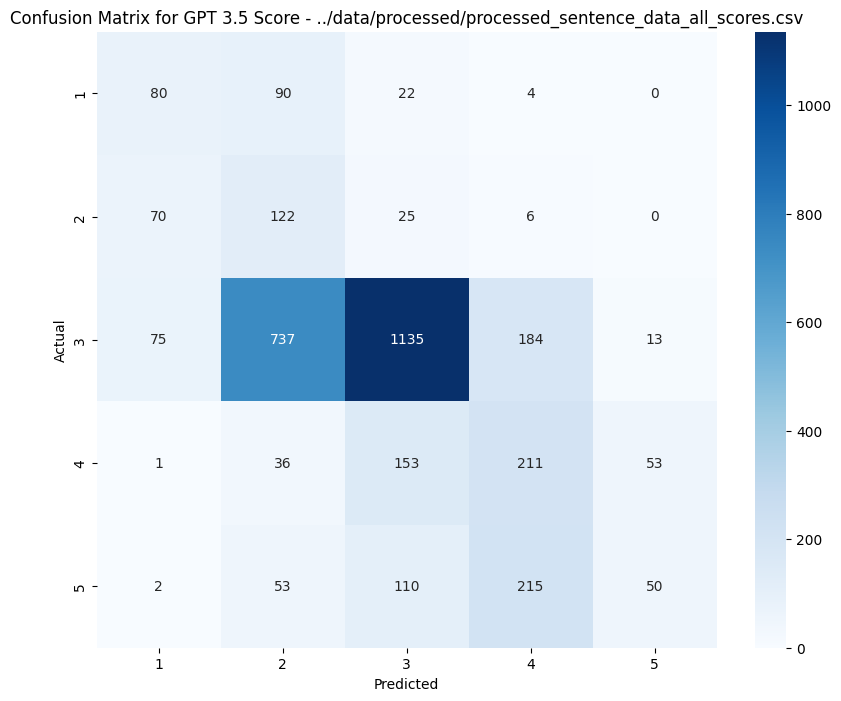

--- Numeric Evaluation for GPT 4.0 Score on ../data/processed/processed_sentence_data_all_scores.csv ---
Accuracy: 0.73
F1 Score: 0.69
              precision    recall  f1-score   support

           1       0.44      0.21      0.28       196
           2       0.46      0.51      0.48       223
           3       0.83      0.96      0.89      2144
           4       0.46      0.45      0.45       454
           5       0.48      0.19      0.28       430

    accuracy                           0.73      3447
   macro avg       0.53      0.46      0.48      3447
weighted avg       0.69      0.73      0.69      3447

--- Categorical Evaluation for GPT 4.0 Score on ../data/processed/processed_sentence_data_all_scores.csv ---
Accuracy: 0.84
F1 Score: 0.84
              precision    recall  f1-score   support

    negative       0.89      0.73      0.80       419
     neutral       0.83      0.96      0.89      2144
    positive       0.89      0.62      0.73       884

    accuracy       

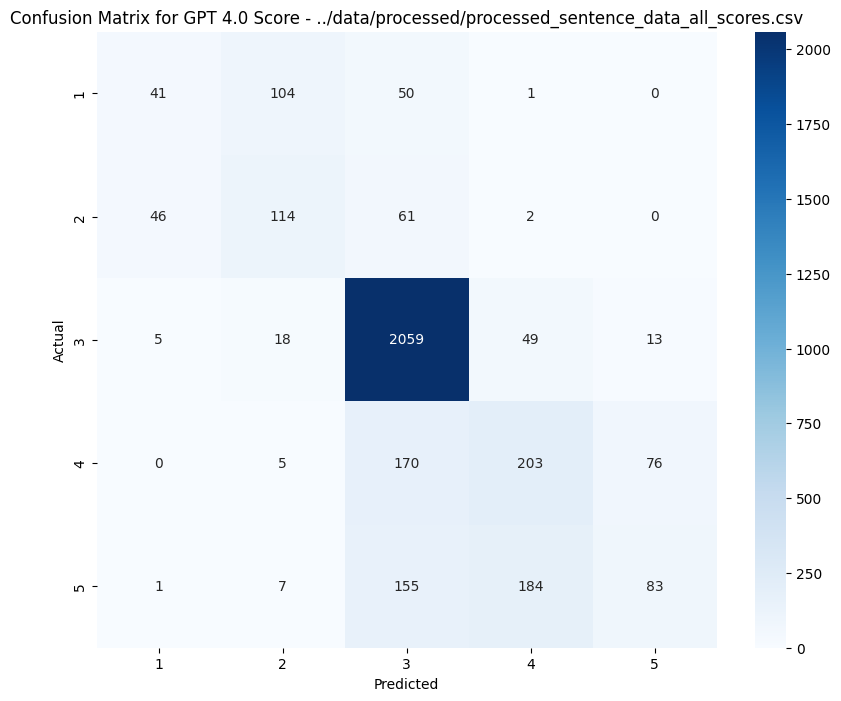

--- Numeric Evaluation for Llama 7B Score on ../data/processed/processed_sentence_data_all_scores.csv ---
Accuracy: 0.21
F1 Score: 0.20
              precision    recall  f1-score   support

           1       0.36      0.35      0.35       196
           2       0.24      0.07      0.11       223
           3       0.66      0.12      0.20      2144
           4       0.09      0.16      0.11       454
           5       0.17      0.77      0.27       430

    accuracy                           0.21      3447
   macro avg       0.30      0.29      0.21      3447
weighted avg       0.48      0.21      0.20      3447

--- Categorical Evaluation for Llama 7B Score on ../data/processed/processed_sentence_data_all_scores.csv ---
Accuracy: 0.37
F1 Score: 0.30
              precision    recall  f1-score   support

    negative       0.73      0.44      0.55       419
     neutral       0.66      0.12      0.20      2144
    positive       0.29      0.94      0.45       884

    accuracy     

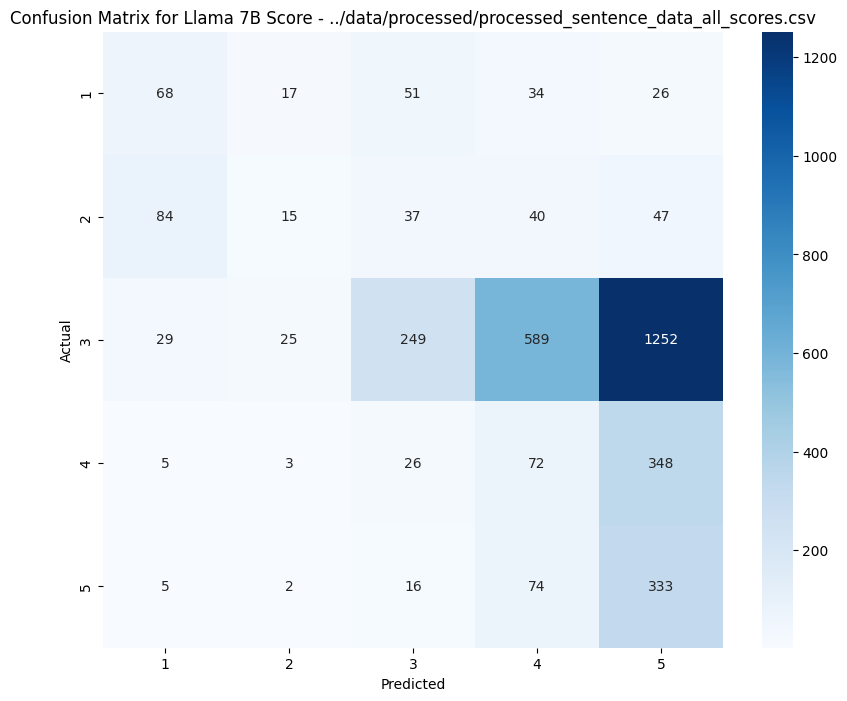

--- Numeric Evaluation for GPT 3.5 Score on ../data/processed/processed_kaggle_combined_data_all_scores.csv ---
Accuracy: 0.36
F1 Score: 0.37
              precision    recall  f1-score   support

           1       0.31      0.40      0.35       428
           2       0.21      0.47      0.29       430
           3       0.61      0.31      0.41      1122
           4       0.32      0.30      0.31       398
           5       0.48      0.39      0.43       471

    accuracy                           0.36      2849
   macro avg       0.39      0.38      0.36      2849
weighted avg       0.44      0.36      0.37      2849

--- Categorical Evaluation for GPT 3.5 Score on ../data/processed/processed_kaggle_combined_data_all_scores.csv ---
Accuracy: 0.59
F1 Score: 0.57
              precision    recall  f1-score   support

    negative       0.49      0.87      0.63       858
     neutral       0.61      0.31      0.41      1122
    positive       0.76      0.67      0.71       869

    a

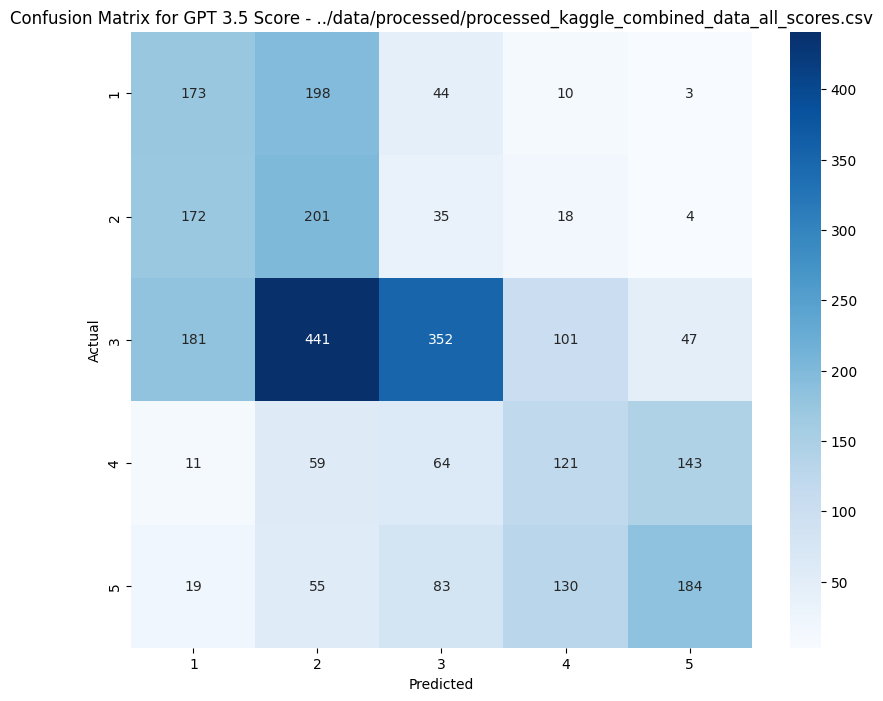

--- Numeric Evaluation for GPT 4.0 Score on ../data/processed/processed_kaggle_combined_data_all_scores.csv ---
Accuracy: 0.48
F1 Score: 0.48
              precision    recall  f1-score   support

           1       0.41      0.21      0.28       428
           2       0.34      0.48      0.40       430
           3       0.65      0.65      0.65      1122
           4       0.28      0.29      0.28       398
           5       0.46      0.48      0.47       471

    accuracy                           0.48      2849
   macro avg       0.43      0.42      0.42      2849
weighted avg       0.48      0.48      0.48      2849

--- Categorical Evaluation for GPT 4.0 Score on ../data/processed/processed_kaggle_combined_data_all_scores.csv ---
Accuracy: 0.70
F1 Score: 0.70
              precision    recall  f1-score   support

    negative       0.73      0.70      0.72       858
     neutral       0.65      0.65      0.65      1122
    positive       0.72      0.76      0.74       869

    a

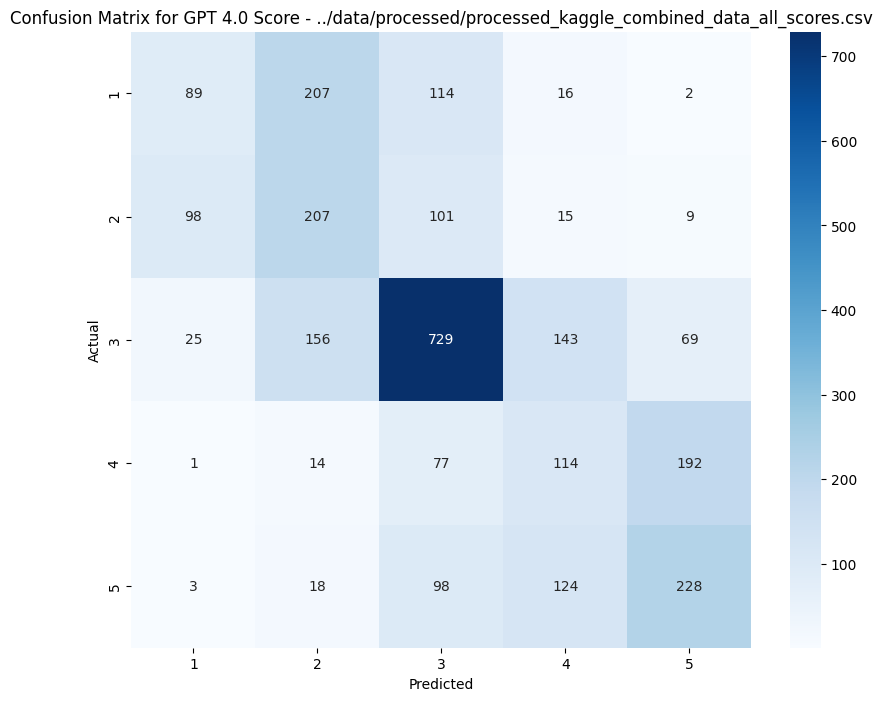

--- Numeric Evaluation for Llama 7B Score on ../data/processed/processed_kaggle_combined_data_all_scores.csv ---
Accuracy: 0.24
F1 Score: 0.19
              precision    recall  f1-score   support

           1       0.33      0.20      0.25       428
           2       0.26      0.03      0.05       430
           3       0.46      0.12      0.19      1122
           4       0.09      0.09      0.09       398
           5       0.22      0.86      0.35       471

    accuracy                           0.24      2849
   macro avg       0.27      0.26      0.19      2849
weighted avg       0.32      0.24      0.19      2849

--- Categorical Evaluation for Llama 7B Score on ../data/processed/processed_kaggle_combined_data_all_scores.csv ---
Accuracy: 0.41
F1 Score: 0.35
              precision    recall  f1-score   support

    negative       0.69      0.25      0.37       858
     neutral       0.46      0.12      0.19      1122
    positive       0.37      0.95      0.53       869

   

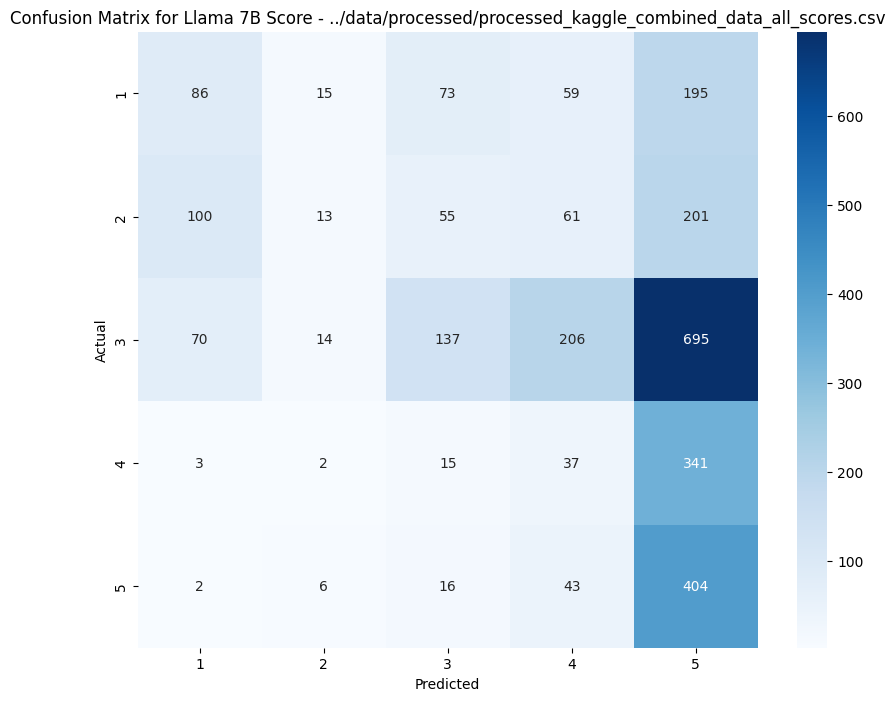

--- Numeric Evaluation for GPT 3.5 Score on ../data/processed/processed_amazon_data_all_scores.csv ---
Accuracy: 0.67
F1 Score: 0.69
              precision    recall  f1-score   support

         1.0       0.50      0.37      0.42       117
         2.0       0.20      0.62      0.31        93
         3.0       0.36      0.33      0.34       331
         4.0       0.36      0.47      0.41       452
         5.0       0.91      0.79      0.85      2029

    accuracy                           0.67      3022
   macro avg       0.47      0.52      0.47      3022
weighted avg       0.73      0.67      0.69      3022

--- Categorical Evaluation for GPT 3.5 Score on ../data/processed/processed_amazon_data_all_scores.csv ---
Accuracy: 0.83
F1 Score: 0.84
              precision    recall  f1-score   support

    negative       0.43      0.77      0.56       210
     neutral       0.36      0.33      0.34       331
    positive       0.96      0.90      0.93      2481

    accuracy           

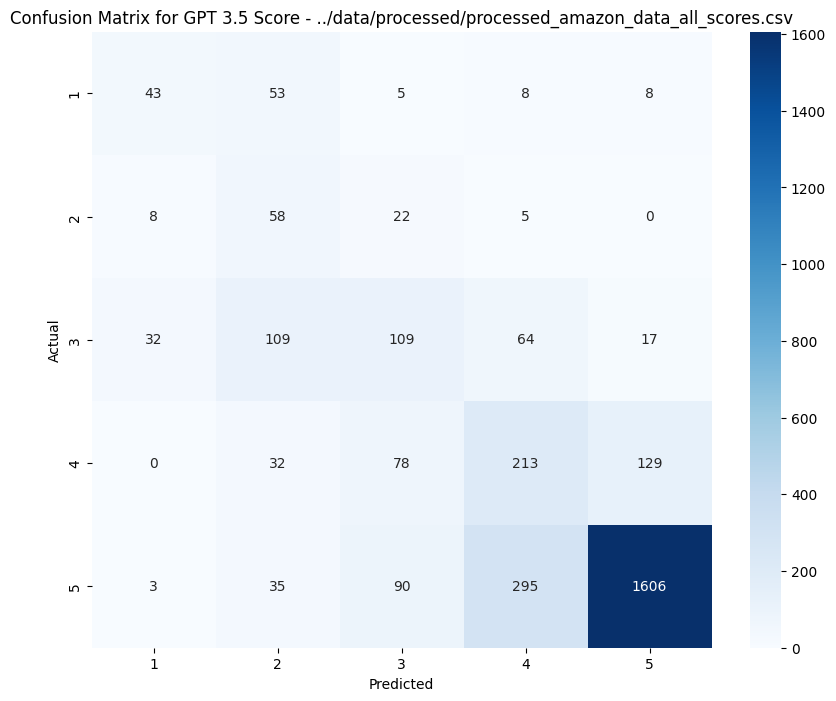

--- Numeric Evaluation for GPT 4.0 Score on ../data/processed/processed_amazon_data_all_scores.csv ---
Accuracy: 0.73
F1 Score: 0.74
              precision    recall  f1-score   support

         1.0       0.48      0.19      0.27       117
         2.0       0.12      0.26      0.17        93
         3.0       0.46      0.54      0.50       331
         4.0       0.48      0.48      0.48       452
         5.0       0.91      0.87      0.89      2029

    accuracy                           0.73      3022
   macro avg       0.49      0.47      0.46      3022
weighted avg       0.75      0.73      0.74      3022

--- Categorical Evaluation for GPT 4.0 Score on ../data/processed/processed_amazon_data_all_scores.csv ---
Accuracy: 0.87
F1 Score: 0.88
              precision    recall  f1-score   support

    negative       0.59      0.68      0.63       210
     neutral       0.46      0.54      0.50       331
    positive       0.97      0.94      0.95      2481

    accuracy           

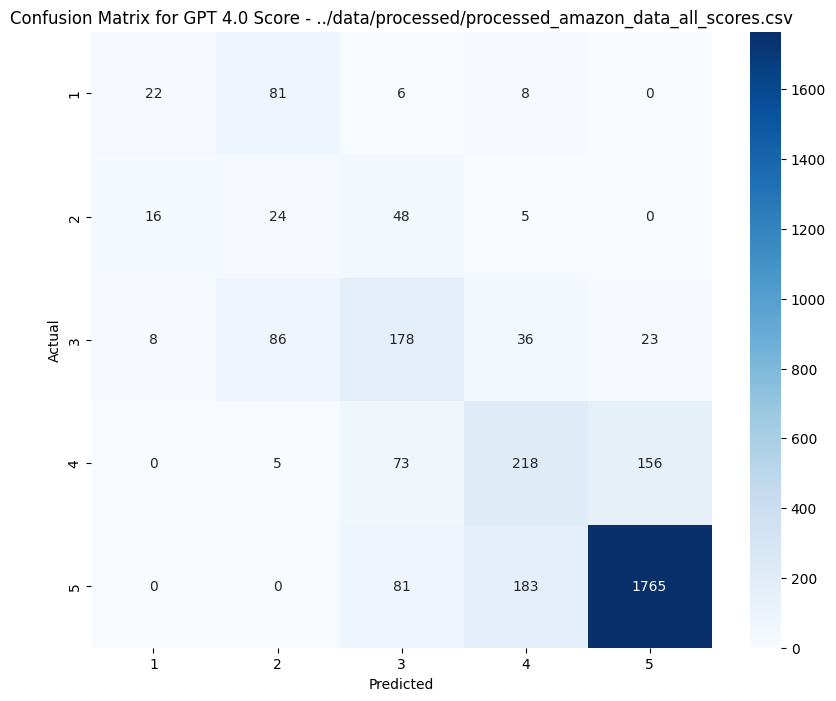

--- Numeric Evaluation for Llama 7B Score on ../data/processed/processed_amazon_data_all_scores.csv ---
Accuracy: 0.69
F1 Score: 0.68
              precision    recall  f1-score   support

         1.0       0.59      0.26      0.36       117
         2.0       0.18      0.04      0.07        93
         3.0       0.33      0.21      0.25       331
         4.0       0.32      0.43      0.37       452
         5.0       0.84      0.88      0.86      2029

    accuracy                           0.69      3022
   macro avg       0.45      0.36      0.38      3022
weighted avg       0.67      0.69      0.68      3022

--- Categorical Evaluation for Llama 7B Score on ../data/processed/processed_amazon_data_all_scores.csv ---
Accuracy: 0.83
F1 Score: 0.80
              precision    recall  f1-score   support

    negative       0.64      0.22      0.33       210
     neutral       0.33      0.21      0.25       331
    positive       0.87      0.97      0.92      2481

    accuracy         

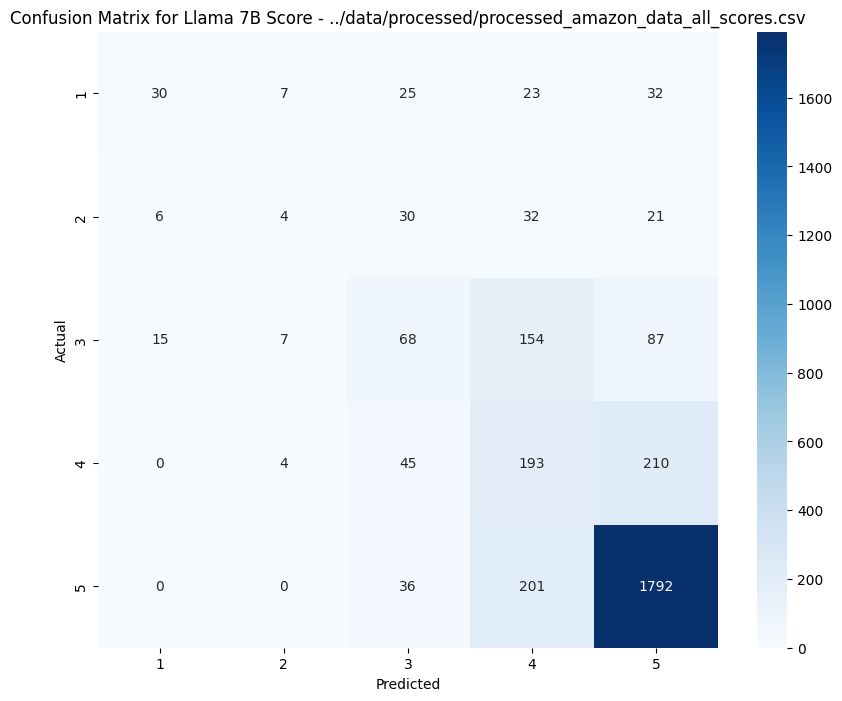

In [24]:
models = ['GPT 3.5 Score', 'GPT 4.0 Score', 'Llama 7B Score']  # Replace with your actual model names
metrics_df = pd.DataFrame()
all_scores_df = pd.DataFrame()


for dataset_file in datasets:
    df = pd.read_csv(dataset_file)
    df.dropna(subset=['Actual_Score'] + models, inplace=True)
    actuals = df['Actual_Score']
    for model in models:
        predictions = df[model]
        numeric_results, categorical_results = evaluate_model(predictions, actuals, model, dataset_file)
        plot_confusion_matrix(predictions, actuals, model, dataset_file)

        # Flatten the results into a single dictionary for the DataFrame
        results_to_store = {
            'Dataset': dataset_file,
            'Model': model,
            'Accuracy (Numeric)': numeric_results['Accuracy (Numeric)'],
            'F1 Score (Numeric)': numeric_results['F1 Score (Numeric)'],
            'Accuracy (Categorical)': categorical_results['Accuracy (Categorical)'],
            'F1 Score (Categorical)': categorical_results['F1 Score (Categorical)']
        }
        metrics_df = pd.concat([metrics_df, pd.DataFrame([results_to_store])], ignore_index=True)

        if all_scores_df.empty:
            # If all_scores_df is empty, initialize it with the score columns
            all_scores_df = df[models].copy()
        else:
            # If all_scores_df already contains data, concatenate along the columns (axis=1)
            all_scores_df = pd.concat([all_scores_df, df[models]], axis=0, ignore_index=True)



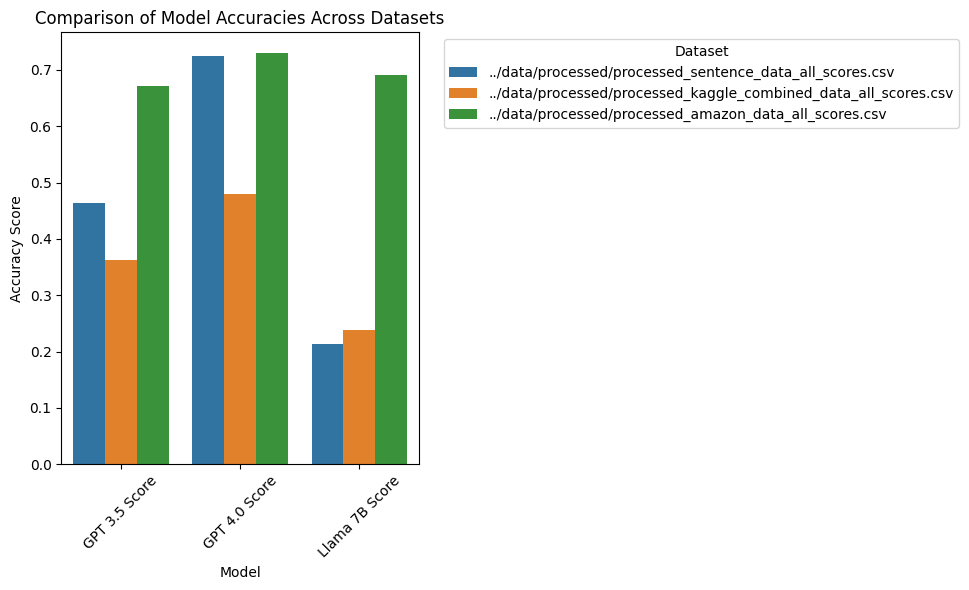

In [27]:
# Filter out the necessary information for the bar graph (model, dataset, accuracy)
accuracy_df = metrics_df[['Model', 'Dataset', 'Accuracy (Numeric)']]

# Create the bar graph
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Model', y='Accuracy (Numeric)', hue='Dataset', data=accuracy_df)

plt.title('Comparison of Model Accuracies Across Datasets')
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.xticks(rotation=45)  
plt.tight_layout() 
plt.show()


### Aggregated Metrics Across all Datasets Per Model

In [19]:
# Aggregate the results by taking the mean of each metric per model
aggregated_metrics = metrics_df.groupby('Model').agg({
    'Accuracy (Numeric)': 'mean',
    'F1 Score (Numeric)': 'mean',
    'Accuracy (Categorical)': 'mean',
    'F1 Score (Categorical)': 'mean'
}).reset_index()


##### Accuracy and F1

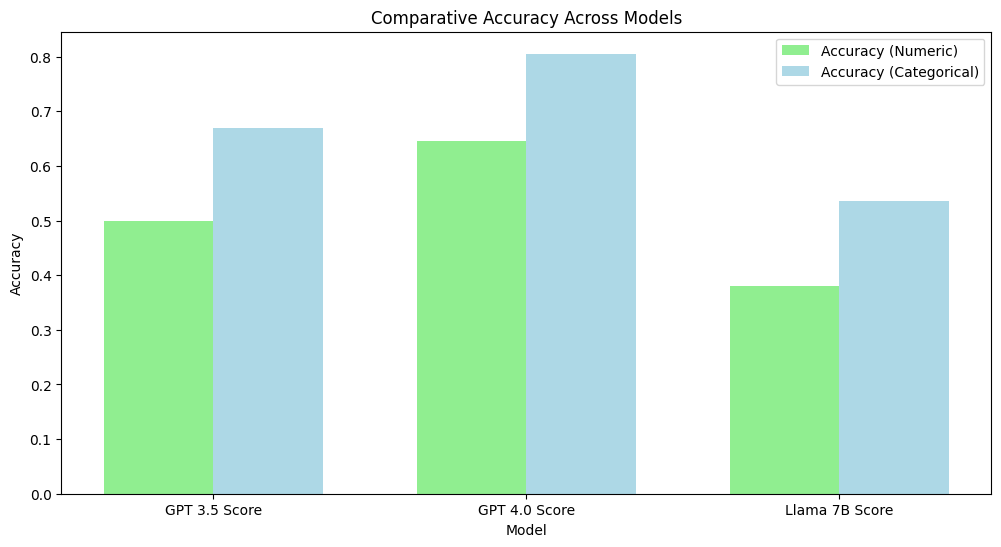

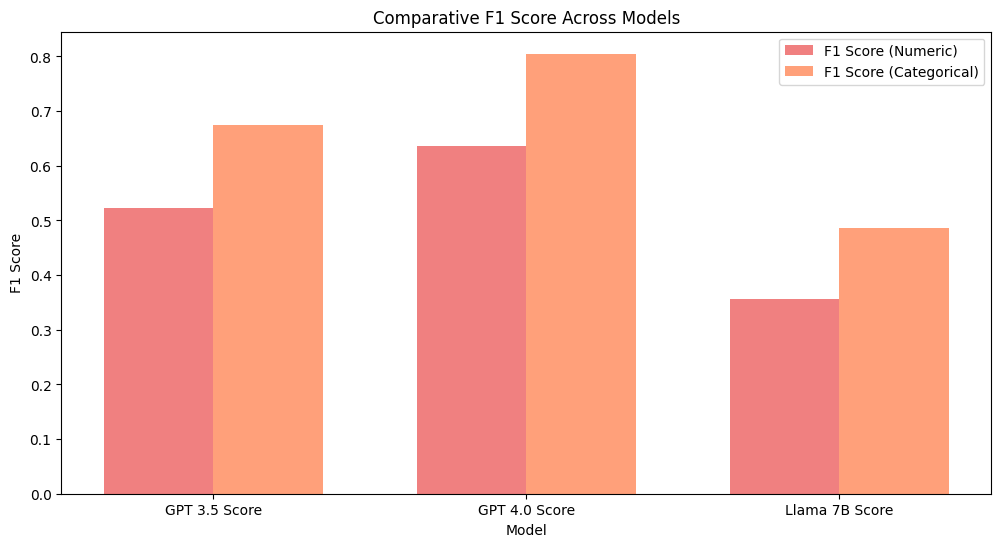

In [20]:
bar_width = 0.35
index = pd.Index(range(len(aggregated_metrics)))

# Create combined plots for accuracy
plt.figure(figsize=(12, 6))
plt.bar(index - bar_width/2, aggregated_metrics['Accuracy (Numeric)'], bar_width, label='Accuracy (Numeric)', color='lightgreen')
plt.bar(index + bar_width/2, aggregated_metrics['Accuracy (Categorical)'], bar_width, label='Accuracy (Categorical)', color='lightblue')
plt.xlabel('Model')
plt.xticks(index, aggregated_metrics['Model'])
plt.ylabel('Accuracy')
plt.title('Comparative Accuracy Across Models')
plt.legend()
plt.show()

# Create combined plots for F1 score
plt.figure(figsize=(12, 6))
plt.bar(index - bar_width/2, aggregated_metrics['F1 Score (Numeric)'], bar_width, label='F1 Score (Numeric)', color='lightcoral')
plt.bar(index + bar_width/2, aggregated_metrics['F1 Score (Categorical)'], bar_width, label='F1 Score (Categorical)', color='lightsalmon')
plt.xlabel('Model')
plt.xticks(index, aggregated_metrics['Model'])
plt.ylabel('F1 Score')
plt.title('Comparative F1 Score Across Models')
plt.legend()
plt.show()

##### Confusion Matrix

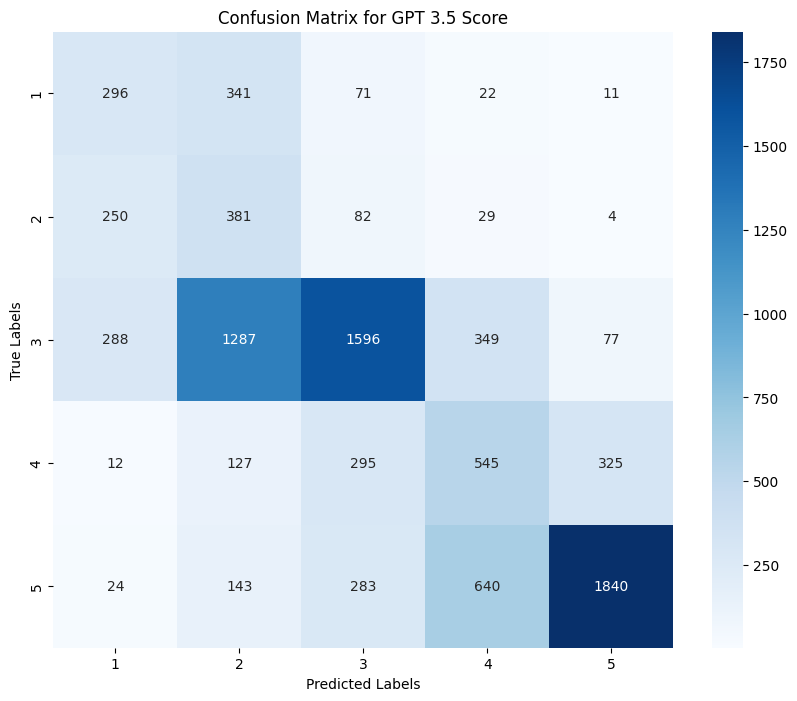

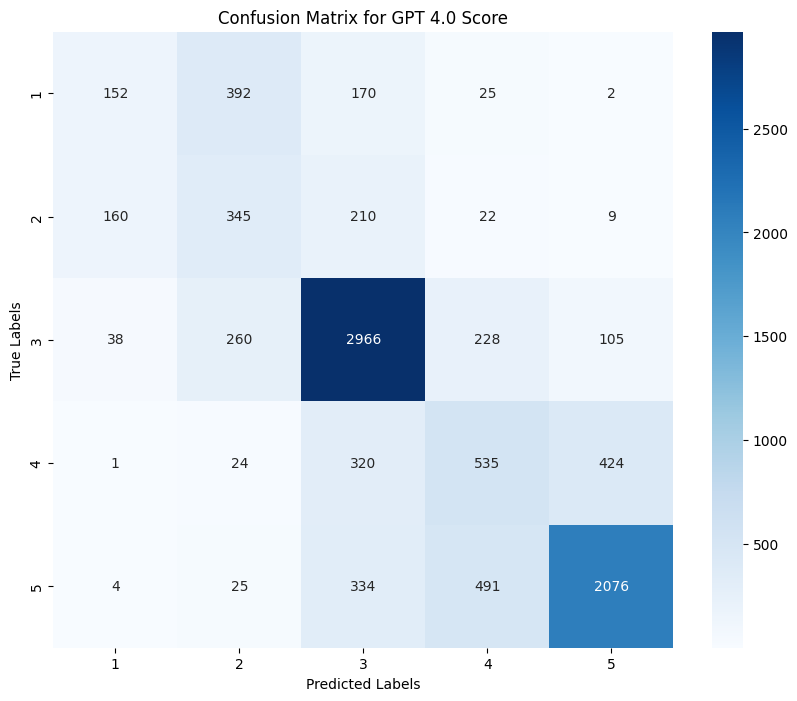

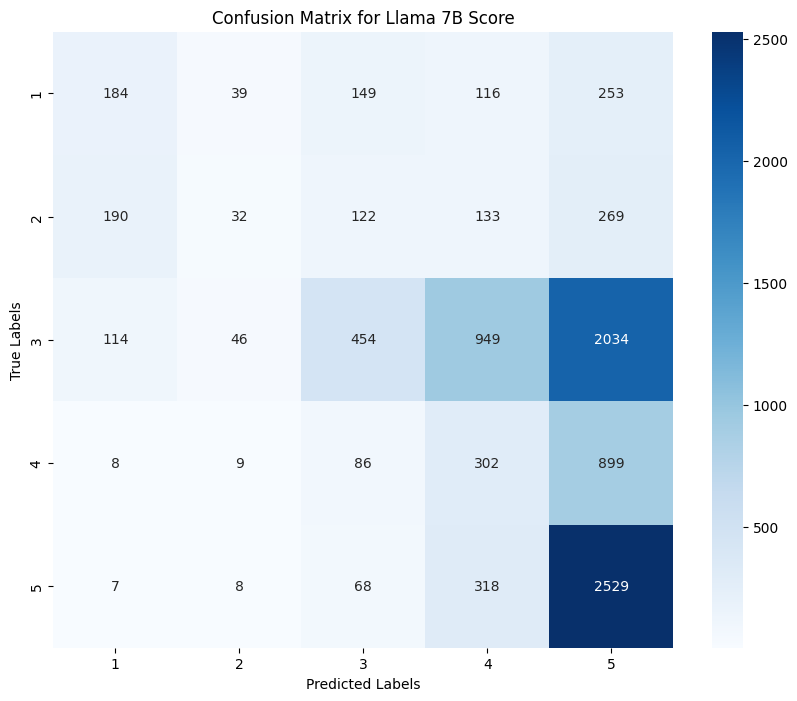

In [28]:
# Dictionary to store predictions and actuals for each model
model_predictions = {model: [] for model in models}
actual_labels = []

# Loop over the dataset files
for dataset_file in datasets:
    # Read the dataset
    df = pd.read_csv(dataset_file)
    df.dropna(subset=['Actual_Score'] + models, inplace=True)

    
    # Extend the actual labels list
    actual_labels.extend(df['Actual_Score'])
    
    # For each model, extend the corresponding predictions list
    for model in models:
        model_predictions[model].extend(df[model])

for model in models:
    # Compute the confusion matrix
    cm = confusion_matrix(actual_labels, model_predictions[model])
    labels = [1, 2, 3, 4, 5]
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix for {model}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
